# SHO Fitter on the noisy data

In [1]:
import sys
sys.path.append('../../')

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import time
import pandas as pd
import os
import shutil
import gc

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from scipy.signal import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 

from src.m3_learning.optimizers.AdaHessian import AdaHessian
from src.m3_learning.nn.SHO_fitter.SHO import SHO_fit_func_torch
from src.m3_learning.be.processing import convert_amp_phase, SHO_Fitter, SHO_fit_to_array
from src.m3_learning.nn.random import random_seed
from src.m3_learning.util.preprocessing import global_scaler
from src.m3_learning.viz.layout import layout_fig

from src.m3_learning.be.util import print_be_tree

from src.m3_learning.viz.printing import printer
from src.m3_learning.viz.layout import combine_lines, labelfigs


printing = printer(basepath='./figures/')

## Loads data

In [8]:
# Sets path to file
path = r"./"

# Opens the data file
h5_f = h5py.File(path + "data_file.h5", "r+")

# number of pixels in the image
num_pix = h5_f["Measurement_000"].attrs["num_pix"]

num_pix_1d = int(np.sqrt(num_pix))

# Frequency Vector in Hz
frequency_bin = h5_f["Measurement_000"]["Channel_000"]["Bin_Frequencies"][:]

# extracting spectroscopic values
spectroscopic_values = h5_f['Measurement_000']['Channel_000']['Spectroscopic_Values']

# number of DC voltage steps
voltage_steps = h5_f["Measurement_000"].attrs["num_udvs_steps"]

# Resampled frequency vector
wvec_freq = resample(frequency_bin, 80)

# get raw data (real and imaginary combined)
raw_data = h5_f["Measurement_000"]["Channel_000"]["Raw_Data"]
raw_data_resampled = resample(np.array(h5_f["Measurement_000"]["Channel_000"]["Raw_Data"]).reshape(-1, 165), 80, axis=1)

# conversion of raw data (both resampled and full)
amp, phase = convert_amp_phase(raw_data)
amp_resample, phase_resample = convert_amp_phase(raw_data_resampled)

scaled_data = h5_f["Measurement_000"]["Channel_000"]['complex']['scaled_data'][:]
real_resample = h5_f["Measurement_000"]["Channel_000"]['complex']['real_resample'][:]
imag_resample = h5_f["Measurement_000"]["Channel_000"]['complex']['imag_resample'][:]

# scale the real component of input data
scaler_real = global_scaler()
scaled_data_real = scaler_real.fit_transform(real_resample).reshape(-1, 80)

# scale the imaginary component of input data
scaler_imag = global_scaler()
scaled_data_imag = scaler_imag.fit_transform(imag_resample).reshape(-1, 80)

OSError: [Errno 0] Unable to open file (unable to lock file, errno = 0, error message = 'No error', Win32 GetLastError() = 33)

In [6]:
# create a list for parameters
fit_results_list = SHO_fit_to_array(h5_f["Measurement_000"]["Channel_000"]["Raw_Data-SHO_Fit_000"]["Fit"])

# flatten parameters list into numpy array
fit_results_list = np.array(fit_results_list).reshape(num_pix, voltage_steps, 5)

# exclude the R2 parameter
params = fit_results_list.reshape(-1, 5)[:, 0:4]

# scale the parameters (now takes only 4 parameters, excluding the R2)
params_scaler = StandardScaler()
scaled_params = params_scaler.fit_transform(fit_results_list.reshape(-1, 5)[:, 0:4])

NameError: name 'h5_f' is not defined

In [12]:
lowest_noise_real = -1.0 * 0.0026878386 # 2.6e-3
highest_noise_real = 1.0 * 0.0026878386
lowest_noise_imag = -1.0 * 0.0027575183
highest_noise_imag = 1.0 * 0.0027575183

noise_real = np.random.uniform(lowest_noise_real, highest_noise_real, (3600, 63360))
noise_imag = np.random.uniform(lowest_noise_imag, highest_noise_imag, (3600, 63360))
noise = noise_real+noise_imag*1.0j

noise_levels = ['2.0', '4.0', '7.0']

In [8]:
# all computations were pre-computed on A100 40GB NHI GPU
# set to False if you want to recompute
use_pre_computed_vars = False
use_pre_trained_models = False

### Copies initial dataset for the later use

In [9]:
if not use_pre_computed_vars:
  # close the current file to perform a copy
  h5_f.close()
  for nl in noise_levels:
    shutil.copy('data_file.h5', f'data_file_noise_{nl}.h5')
    time.sleep(3)

In [10]:
h5_f_noise = h5py.File(f'data_file_noise_2.0.h5', 'r+')
h5_f_noise['Measurement_000']['Channel_000']['Raw_Data'] = 0 

OSError: Unable to create link (name already exists)

In [23]:
for noise_level in noise_levels:
  
  with h5py.File(f'data_file_noise_{noise_level}.h5', 'r+') as h5_f_noise:
    data_pointer = h5_f_noise['Measurement_000']['Channel_000']['Raw_Data']
    raw_data_noise = np.array(h5_f_noise['Measurement_000']['Channel_000']['Raw_Data'])
    raw_data_noise = raw_data_noise + noise * float(noise_level) 
    data_pointer[...] = raw_data_noise

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

C:\Users\Joshua Agar\AppData\Roaming\Python\Python310\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


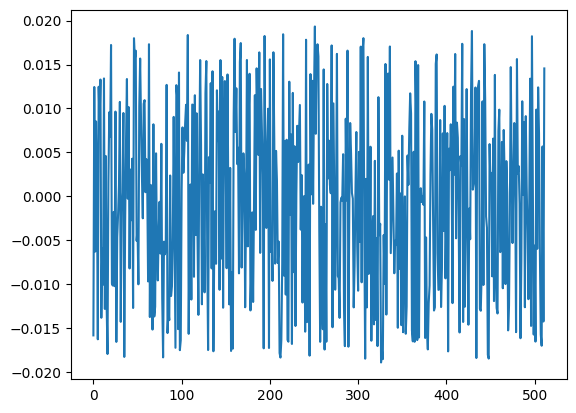

In [24]:
with h5py.File(f'data_file_noise_7.0.h5', 'r+') as h5_f_noise:
    plt.plot(h5_f_noise['Measurement_000']['Channel_000']['Raw_Data'][0][0:512])
    print(h5_f_noise['Measurement_000']['Channel_000']['Raw_Data'][0][0:512]== h5_f['Measurement_000']['Channel_000']['Raw_Data'][0][0:512])

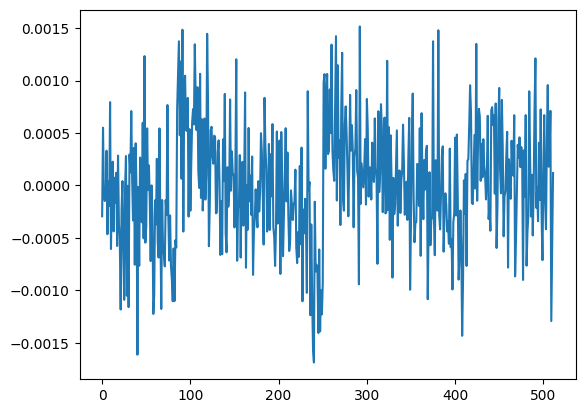

In [25]:
with h5py.File(r'C:\Users\Joshua Agar\Documents\codes\m3_learning\m3_learning\papers\2023_Rapid_Fitting\data_file.h5', 'r+') as h5_f_noise:
    plt.plot(h5_f_noise['Measurement_000']['Channel_000']['Raw_Data'][0][0:512])

## Builds the PyTorch model

In [26]:
class SHO_Model(nn.Module):
    def __init__(self):
        super().__init__()

        # Input block of 1d convolution
        self.hidden_x1 = nn.Sequential(
            nn.Conv1d(in_channels=2, out_channels=8, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=8, out_channels=6, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=6, out_channels=4, kernel_size=5),
            nn.SELU(),
        )

        # fully connected block
        self.hidden_xfc = nn.Sequential(
            nn.Linear(256, 20),
            nn.SELU(),
            nn.Linear(20, 20),
            nn.SELU(),
        )

        # 2nd block of 1d-conv layers
        self.hidden_x2 = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Conv1d(in_channels=4, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
        )

        # Flatten layer
        self.flatten_layer = nn.Flatten()

        # Final embedding block - Output 4 values - linear
        self.hidden_embedding = nn.Sequential(
            nn.Linear(26, 16),
            nn.SELU(),
            nn.Linear(16, 8),
            nn.SELU(),
            nn.Linear(8, 4),
        )

    def forward(self, x, n=-1):
        x = torch.swapaxes(x, 1, 2)  # output shape - samples, (real, imag), frequency
        x = self.hidden_x1(x)
        xfc = torch.reshape(x, (n, 256))  # batch size, features
        xfc = self.hidden_xfc(xfc)
        x = torch.reshape(x, (n, 2, 128))  # batch size, (real, imag), timesteps
        x = self.hidden_x2(x)
        cnn_flat = self.flatten_layer(x)
        encoded = torch.cat((cnn_flat, xfc), 1)  # merge dense and 1d conv.
        embedding = self.hidden_embedding(encoded)  # output is 4 parameters

        # corrects the scaling of the parameters
        unscaled_param = (
            embedding * torch.tensor(params_scaler.var_[0:4] ** 0.5).cuda()
            + torch.tensor(params_scaler.mean_[0:4]).cuda()
        )

        # passes to the pytorch fitting function
        fits = SHO_fit_func_torch(unscaled_param, wvec_freq, device="cuda")

        # extract and return real and imaginary
        real = torch.real(fits)
        real_scaled = (real - torch.tensor(scaler_real.mean).cuda()) / torch.tensor(
            scaler_real.std
        ).cuda()
        imag = torch.imag(fits)
        imag_scaled = (imag - torch.tensor(scaler_imag.mean).cuda()) / torch.tensor(
            scaler_imag.std
        ).cuda()
        out = torch.stack((real_scaled, imag_scaled), 2)
        return out

## Trains NN

### Train/Test Split

In [27]:
data_train, data_test, params_train, params_test = train_test_split(
    scaled_data, scaled_params, test_size=0.7, random_state=42
)

params_test_unscaled = params_scaler.inverse_transform(params_test)

### Training

In [28]:
if not use_pre_trained_models:
  max_num_of_updates = scaled_data.shape[0] // 16 * 10
  output_tensor_dict = {}
  seed = 0
  noise_reshaped = resample(noise.reshape(-1, 165), 80, axis=1)
  noise_2d = np.stack((np.real(noise_reshaped), np.imag(noise_reshaped)), axis=2)
  noise_train, noise_test = train_test_split(noise_2d, test_size=0.7, random_state=42)

In [29]:
if not use_pre_trained_models:
  for noise_factor in noise_levels:
      noise_factor = float(noise_factor)
      random_seed(seed=42)
      torch.cuda.empty_cache()
      model = SHO_Model().cuda()

      loss_func = torch.nn.MSELoss()
      batch_size = 128
      data_noise = scaled_data + noise_2d * noise_factor
      data_train_noise = data_train + noise_train * noise_factor
      data_test_noise = data_test + noise_test * noise_factor

      optimizer = torch.optim.Adam(model.parameters())
      train_dataloader = DataLoader(data_train_noise, batch_size=batch_size)
      epochs = max_num_of_updates * batch_size // scaled_data.shape[0] // 16
      print(f"Training with batch size = {batch_size}, noise factor = {noise_factor}")
      start_time_training = time.time()
      for epoch in range(epochs):
          start_time = time.time()
          train_loss = 0.
          total_num = 0

          model.train()

          for train_batch in train_dataloader:
              pred = model(train_batch.double().cuda())
              optimizer.zero_grad()
              loss = loss_func(train_batch.double().cuda(), pred)
              loss.backward(create_graph=True)
              train_loss += loss.item() * pred.shape[0]
              total_num += pred.shape[0]
              optimizer.step()

          train_loss /= total_num
          torch.save(model.state_dict(), f'./Trained Models/SHO Fitter/model_noise_{noise_factor}_bs128.pt')

          print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, train_loss))
          print("--- %s seconds ---" % (time.time() - start_time))

      print(f"Training with batch size={batch_size} took {time.time() - start_time_training} seconds\n")

      del train_dataloader
      del data_noise
      del data_train_noise
      del data_test_noise
      del model
      gc.collect()
      torch.cuda.empty_cache()

Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42
Training with batch size = 128, noise factor = 2.0


c:\Conda\envs\m3_learning\lib\site-packages\torch\autograd\__init__.py:204: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ..\torch\csrc\autograd\engine.cpp:1151.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch : 1/5, recon loss = 0.06894933
--- 46.79527187347412 seconds ---
epoch : 2/5, recon loss = 0.04359906
--- 39.664793968200684 seconds ---
epoch : 3/5, recon loss = 0.04301231
--- 39.77002835273743 seconds ---
epoch : 4/5, recon loss = 0.04271595
--- 40.18890714645386 seconds ---
epoch : 5/5, recon loss = 0.04255632
--- 40.48651671409607 seconds ---
Training with batch size=128 took 206.90551805496216 seconds

Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42
Training with batch size = 128, noise factor = 4.0
epoch : 1/5, recon loss = 0.06898030
--- 35.371275186538696 seconds ---
epoch : 2/5, recon loss = 0.04358153
--- 31.85748267173767 seconds ---
epoch : 3/5, recon loss = 0.04300492
--- 30.1507728099823 seconds ---
epoch : 4/5, recon loss = 0.04272683
--- 37.75629496574402 seconds ---
epoch : 5/5, recon loss = 0.04254891
--- 44.430644035339355 seconds ---
Training with batch size=128 took 179.56646966934204 seconds

Pytorch seed was set to 42
Nump

### Computes fits

In [30]:
for noise_level in noise_levels:
    SHO_Fitter(f'data_file_noise_{noise_level}.h5', force=True)
    print(f'Computation for noise level={noise_level} is done!')

C:\Users\Joshua Agar\AppData\Roaming\Python\Python310\site-packages\sidpy\sid\translator.py:42: FutureWarning: Consider using sidpy.Reader instead of sidpy.Translator if possible and contribute your reader to ScopeReaders
  warn('Consider using sidpy.Reader instead of sidpy.Translator if '
C:\Users\Joshua Agar\AppData\Roaming\Python\Python310\site-packages\BGlib\be\translators\labview_h5_patcher.py:132: UserWarning: 'channel_type' was not found as an attribute of /Measurement_000/Channel_000.
If this is BEPS or BELine data from the LabView aquisition software, please run the following piece of code.  Afterwards, run this function again.
CODE: hdf.file['/Measurement_000/Channel_000'].attrs['channel_type'] = 'BE'
  warn(warn_str)


Working on:
data_file_noise_2.0.h5
['Y', 'X'] [60, 60]


SHO Fits will be written to:
data_file_noise_2.0.h5


Consider calling test() to check results before calling compute() which computes on the entire dataset and writes results to the HDF5 file

Note: SHO_Fit has already been performed PARTIALLY with the same parameters. compute() will resuming computation in the last group below. To choose a different group call use_patial_computation()Set override to True to force fresh computation or resume from a data group besides the last in the list.

[<HDF5 group "/Raw_Data-SHO_Fit_000" (7 members)>]

Note: SHO_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Raw_Data-SHO_Fit_000" (7 members)>]
	This class (likely) supports interruption and resuming of computations!
	If you are operating in a python console, press Ctrl+C or Cmd+C to abort
	If you are in a J

C:\Users\Joshua Agar\AppData\Roaming\Python\Python310\site-packages\BGlib\be\analysis\utils\be_sho.py:96: RuntimeWarning: divide by zero encountered in double_scalars
  Q_fit = -sqrt(d) / c


Rank 0 - 100% complete. Time remaining: 0.0 msec
Finished processing the entire dataset!

Note: SHO_Fit has already been performed PARTIALLY with the same parameters. compute() will resuming computation in the last group below. To choose a different group call use_patial_computation()Set override to True to force fresh computation or resume from a data group besides the last in the list.

[<HDF5 group "/Raw_Data-SHO_Fit_000" (7 members)>]


C:\Users\Joshua Agar\AppData\Roaming\Python\Python310\site-packages\BGlib\be\analysis\fitter.py:140: UserWarning: status dataset not created yet
  warn('status dataset not created yet')


Resuming computation. 0% completed already
	This class (likely) supports interruption and resuming of computations!
	If you are operating in a python console, press Ctrl+C or Cmd+C to abort
	If you are in a Jupyter notebook, click on "Kernel">>"Interrupt"
	If you are operating on a cluster and your job gets killed, re-run the job to resume

Rank 0 - 100% complete. Time remaining: 0.0 msec
Finished processing the entire dataset!
LSQF method took 1140.1305983066559 seconds to compute parameters
Computation for noise level=2.0 is done!


C:\Users\Joshua Agar\AppData\Roaming\Python\Python310\site-packages\sidpy\sid\translator.py:42: FutureWarning: Consider using sidpy.Reader instead of sidpy.Translator if possible and contribute your reader to ScopeReaders
  warn('Consider using sidpy.Reader instead of sidpy.Translator if '
C:\Users\Joshua Agar\AppData\Roaming\Python\Python310\site-packages\BGlib\be\translators\labview_h5_patcher.py:132: UserWarning: 'channel_type' was not found as an attribute of /Measurement_000/Channel_000.
If this is BEPS or BELine data from the LabView aquisition software, please run the following piece of code.  Afterwards, run this function again.
CODE: hdf.file['/Measurement_000/Channel_000'].attrs['channel_type'] = 'BE'
  warn(warn_str)


Working on:
data_file_noise_4.0.h5
['Y', 'X'] [60, 60]


SHO Fits will be written to:
data_file_noise_4.0.h5


Consider calling test() to check results before calling compute() which computes on the entire dataset and writes results to the HDF5 file

Note: SHO_Fit has already been performed PARTIALLY with the same parameters. compute() will resuming computation in the last group below. To choose a different group call use_patial_computation()Set override to True to force fresh computation or resume from a data group besides the last in the list.

[<HDF5 group "/Raw_Data-SHO_Fit_000" (7 members)>]

Note: SHO_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Raw_Data-SHO_Fit_000" (7 members)>]
	This class (likely) supports interruption and resuming of computations!
	If you are operating in a python console, press Ctrl+C or Cmd+C to abort
	If you are in a J

C:\Users\Joshua Agar\AppData\Roaming\Python\Python310\site-packages\BGlib\be\analysis\fitter.py:140: UserWarning: status dataset not created yet
  warn('status dataset not created yet')


Resuming computation. 0% completed already
	This class (likely) supports interruption and resuming of computations!
	If you are operating in a python console, press Ctrl+C or Cmd+C to abort
	If you are in a Jupyter notebook, click on "Kernel">>"Interrupt"
	If you are operating on a cluster and your job gets killed, re-run the job to resume

Rank 0 - 100% complete. Time remaining: 0.0 msec
Finished processing the entire dataset!
LSQF method took 1117.8139343261719 seconds to compute parameters
Computation for noise level=4.0 is done!


C:\Users\Joshua Agar\AppData\Roaming\Python\Python310\site-packages\sidpy\sid\translator.py:42: FutureWarning: Consider using sidpy.Reader instead of sidpy.Translator if possible and contribute your reader to ScopeReaders
  warn('Consider using sidpy.Reader instead of sidpy.Translator if '
C:\Users\Joshua Agar\AppData\Roaming\Python\Python310\site-packages\BGlib\be\translators\labview_h5_patcher.py:132: UserWarning: 'channel_type' was not found as an attribute of /Measurement_000/Channel_000.
If this is BEPS or BELine data from the LabView aquisition software, please run the following piece of code.  Afterwards, run this function again.
CODE: hdf.file['/Measurement_000/Channel_000'].attrs['channel_type'] = 'BE'
  warn(warn_str)


Working on:
data_file_noise_7.0.h5
['Y', 'X'] [60, 60]


SHO Fits will be written to:
data_file_noise_7.0.h5


Consider calling test() to check results before calling compute() which computes on the entire dataset and writes results to the HDF5 file

Note: SHO_Fit has already been performed PARTIALLY with the same parameters. compute() will resuming computation in the last group below. To choose a different group call use_patial_computation()Set override to True to force fresh computation or resume from a data group besides the last in the list.

[<HDF5 group "/Raw_Data-SHO_Fit_000" (7 members)>]

Note: SHO_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Raw_Data-SHO_Fit_000" (7 members)>]
	This class (likely) supports interruption and resuming of computations!
	If you are operating in a python console, press Ctrl+C or Cmd+C to abort
	If you are in a J

C:\Users\Joshua Agar\AppData\Roaming\Python\Python310\site-packages\BGlib\be\analysis\utils\be_sho.py:96: RuntimeWarning: divide by zero encountered in double_scalars
  Q_fit = -sqrt(d) / c


Rank 0 - 100% complete. Time remaining: 0.0 msec
Finished processing the entire dataset!

Note: SHO_Fit has already been performed PARTIALLY with the same parameters. compute() will resuming computation in the last group below. To choose a different group call use_patial_computation()Set override to True to force fresh computation or resume from a data group besides the last in the list.

[<HDF5 group "/Raw_Data-SHO_Fit_000" (7 members)>]


C:\Users\Joshua Agar\AppData\Roaming\Python\Python310\site-packages\BGlib\be\analysis\fitter.py:140: UserWarning: status dataset not created yet
  warn('status dataset not created yet')


Resuming computation. 0% completed already
	This class (likely) supports interruption and resuming of computations!
	If you are operating in a python console, press Ctrl+C or Cmd+C to abort
	If you are in a Jupyter notebook, click on "Kernel">>"Interrupt"
	If you are operating on a cluster and your job gets killed, re-run the job to resume

Rank 0 - 100% complete. Time remaining: 0.0 msec
Finished processing the entire dataset!
LSQF method took 1788.9103500843048 seconds to compute parameters
Computation for noise level=7.0 is done!


### Uses Pre-computed Noisy SHO Fits

In [ ]:
# TODO: download from Zenodo

In [ ]:
if use_pre_computed_vars:
  !unzip noisy_sho_fits.zip